# LeNet

This notebook trains the LeNet-5 neural network on the MNIST database.

#### Imports

In [577]:
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import time
from typing import Any, Dict
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models.torch_lenet import TorchLeNet
import src.data.data as data
import src.misc.adversarial as adversarial

importlib.reload(data)
importlib.reload(adversarial)

SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Training

- `_framework`: Only `"torch"` is currently supported
- `_val_split`: Fraction of the train data to split into a withheld validation set
- `_rotation_degrees`: Sets the maximum degrees of random rotation applied to the train data
- `_crop_padding`: Sets the maximum pixels of random padding applied to the train data
- `_duplicate_with_augment`: If True, duplicates train images when appling data augmentation (crop, rotation)
- `_init`: Weight initialization method
- `_optimizer`: Weight optimization method
- `_activation`: Non-linear activation function used in the model
- `_lr`: Learning rate
- `_seed`: Random seed

The filename/path where a model is saved describes all these attributes.

In [529]:
_framework = "torch"  #@param ["torch", "jax"]
_val_split = 0.1  #@param
_rotation_degrees = 0  #@param
_crop_padding = 0  #@param
_duplicate_with_augment = False  # Adds --duplicate_with_augment flag
_init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
_lr = 3e-4  #@param
_seed = SEED  #@param


model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
model_path = model_name + '.pth'
print(model_path)

src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


In [522]:
# Run this to train a model!
! python src/train.py --framework={_framework} \
    --val_split={_val_split} \
    --rotation_degrees={_rotation_degrees} \
    --crop_padding={_crop_padding} \
    {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
    --init={_init} \
    --optimizer={_optimizer} \
    --activation={_activation} \
    --lr={_lr} \
    --seed={_seed}

---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 relu
Learning Rate:              0.0003
Random Seed:                12
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: src/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

---------------------------------------------
TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2

### Evaluation

In [530]:
from models.torch_lenet import TorchLeNet

print(f'Loading model at: {model_path}')

def get_model_params(model_path: str) -> Dict[str, Any]:
    model_params = model_path.replace(".pth", "").split("_")
    assert len(model_params) == 11
    
    params_dict = {}
    params_dict["framework"] = model_params[1]
    params_dict["val_split"] = float(model_params[2])
    params_dict["rotation_degrees"] = int(model_params[3])
    params_dict["crop_padding"] = int(model_params[4])
    params_dict["duplicate_with_augment"] = model_params[5]
    params_dict["init"] = model_params[6]
    params_dict["optimizer"] = model_params[7]
    params_dict["activation"] = model_params[8]
    params_dict["lr"] = float(model_params[9])
    params_dict["seed"] = int(model_params[10])

    return params_dict
    
# Load model
model_params = get_model_params(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet5 = TorchLeNet(act_fn=model_params["activation"], init=model_params["init"]).to(device)
lenet5.load_state_dict(torch.load(model_path))

# Read training run metadata from JSON
with open(f'{model_name}.json', "r") as f:
    model_metadata = json.load(f)

print(f'Training run metadata: {model_metadata}')

Loading model at: src/models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth
Training run metadata: {'epochs': 13, 'train_time': 370.67990612983704, 'test_accuracy': 0.9848}


In [531]:
_train_dataset, test_dataset, _val_dataset = data.get_MNIST()

test_x = test_dataset.data.unsqueeze(1).float()
test_y = test_dataset.targets

lenet5.eval()
test_x, test_y = test_x.to(device), test_y.to(device)
with torch.no_grad():
    logits = lenet5(test_x)
    test_preds = logits.argmax(axis=1)
    accuracy = (test_preds == test_y).sum() / len(test_y)

print(f'Test Set Accuracy: {100 * accuracy:.2f}%')

Test Set Accuracy: 97.34%


### Ablations

In [ ]:
# Data augmentation
# Compare {no augmentation} to {crop only}, {crop with duplicate}, {rotate only}, {rotate with duplicate}, {crop+rotate}, {crop+rotate with duplicate}

In [ ]:
for _lr in [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
    for _optimizer in ["sgd", "adam", "adamw"]:
        _framework = "torch"  #@param ["torch", "jax"]
        _val_split = 0.1  #@param
        _rotation_degrees = 0  #@param
        _crop_padding = 0  #@param
        _duplicate_with_augment = False  # Adds --duplicate_with_augment flag
        _init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
        #_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
        _activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
        #_lr = 3e-4  #@param
        _seed = SEED  #@param
        
        
        model_name = f'src/models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}'
        model_path = model_name + '.pth'
        print(model_path)

        ! python src/train.py --framework={_framework} \
            --val_split={_val_split} \
            --rotation_degrees={_rotation_degrees} \
            --crop_padding={_crop_padding} \
            {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
            --init={_init} \
            --optimizer={_optimizer} \
            --activation={_activation} \
            --lr={_lr} \
            --seed={_seed}

### Interpretability

In [586]:
import src.misc.interp as interp

importlib.reload(interp)

<module 'src.misc.interp' from '/Users/nicholascarolan/lenet-5/src/misc/interp.py'>

#### Saliency Maps

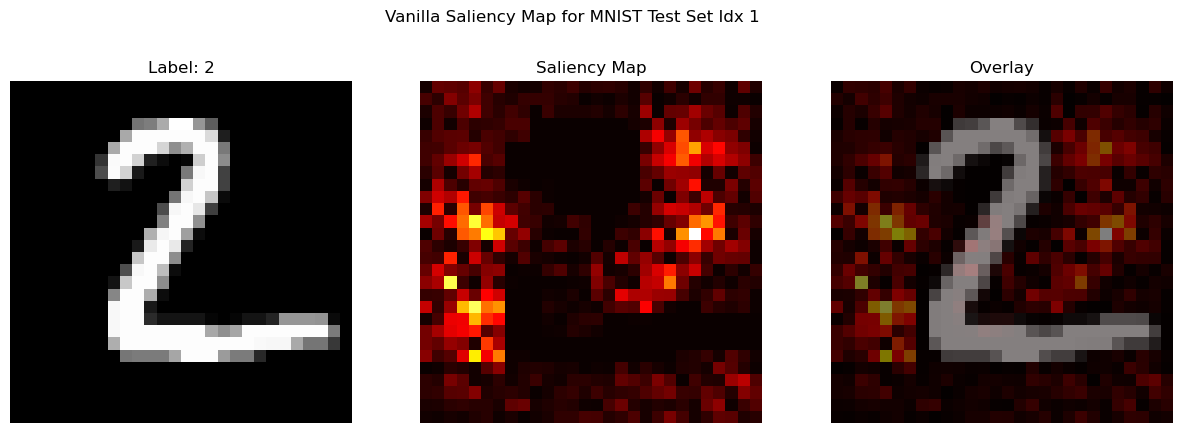

In [587]:
test_idx = 1  #@param

x, y = test_x[test_idx], test_y[test_idx]

sal = interp.saliency_map(lenet5, x, y)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Vanilla Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="gray"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(sal.numpy(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

Notice how the digit pixels have the lowest gradient.
In an attempt to highlight which parts of the writing contribute to the class, we can visualize Gradient × Input.

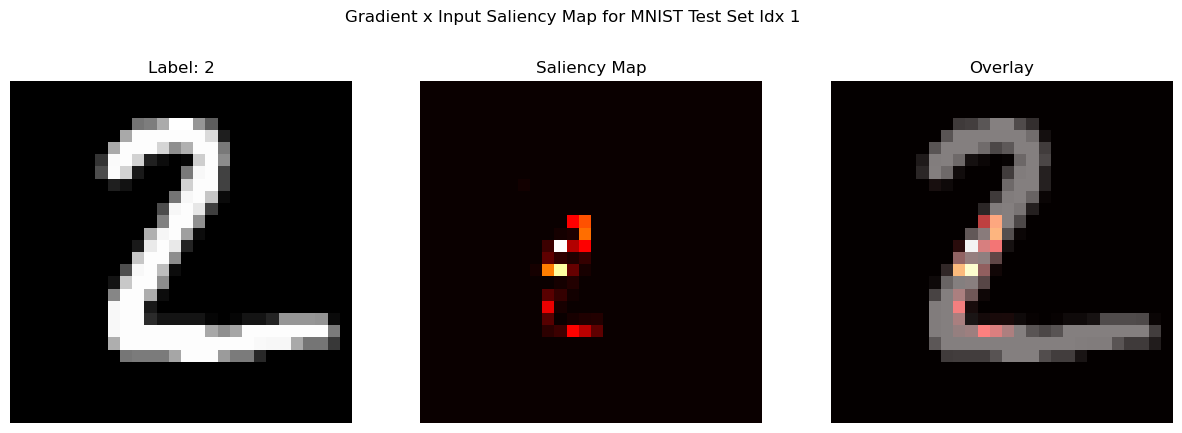

In [590]:
inp_sal = interp.saliency_map(lenet5, x, y, grad_times_input=True)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Gradient x Input Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="gray"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(inp_sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(inp_sal.numpy(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

#### Grad-CAM

In [435]:
print(lenet5)  # Check layer names. These can be the target_layer for GradCAM, e.g. target_layer=lenet5.pool2

TorchLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (act_fn): ReLU()
)


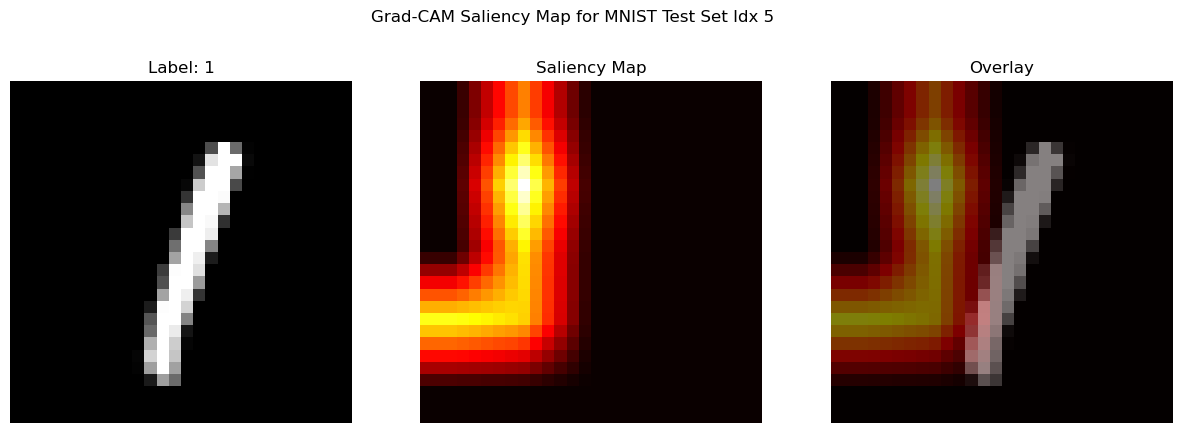

In [436]:
test_idx = 5  #@param

x, y = test_x[test_idx], test_y[test_idx]

vis = grad_cam(
    model=lenet5,
    input_tensor=x,
    target_layer=lenet5.pool2,
    target_class=y,
    normalize=True,)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Grad-CAM Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze(), cmap="grey"); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(vis.numpy().squeeze(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off");
ax[2].imshow(x.squeeze(), cmap="gray"); ax[2].imshow(vis.numpy().squeeze(), cmap="hot", alpha=0.5); ax[2].set_title("Overlay"); ax[2].axis("off"); plt.show()

#### Sparse Autoencoders (SAEs)

In [ ]:
# Record activations from many forward passes in the network. 
# Then train an autoencoder to learn some sparse feature set from the activations at a chosen layer, probably fc1?

### Adversarial Examples

In [ ]:
import src.misc.adversarial as adversarial

importlib.reload(adversarial)

In [532]:
_train_dataset, test_dataset, _val_dataset = data.get_MNIST()

MNIST_TRAIN_MEAN = test_dataset.data.float().mean()
MNIST_TRAIN_STD = test_dataset.data.float().std()
MNIST_DIM = 255

def mnist_normalize(x):
    """Normalize MNIST tensor to zero-mean, unit-std scale."""
    return (x - MNIST_TRAIN_MEAN) / MNIST_TRAIN_STD

def mnist_denormalize(x):
    """Reverse normalization back to pixel scale."""
    x =  x * MNIST_TRAIN_STD + MNIST_TRAIN_MEAN
    return torch.clamp(x, 0, MNIST_DIM)

#### Fast Gradient Sign Method

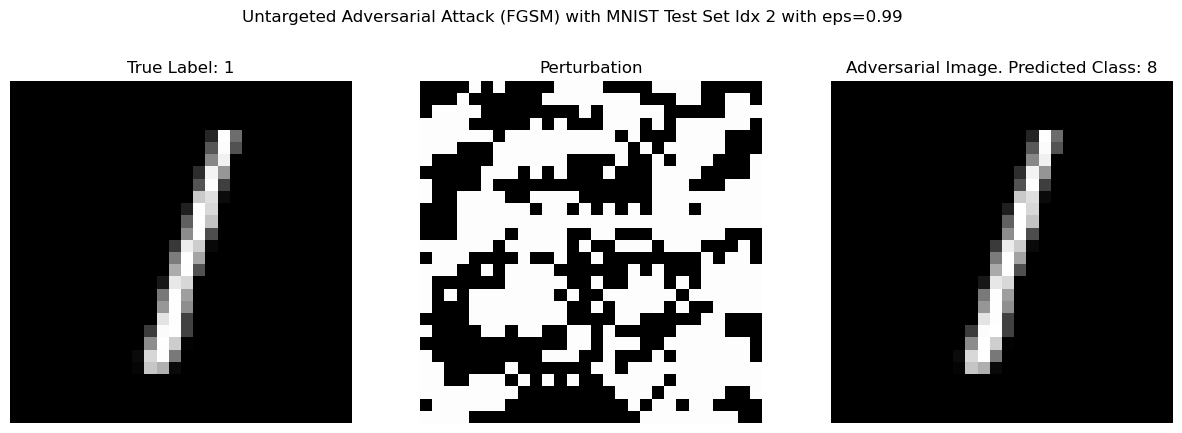

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -2.03   2.31   2.35   1.16  -0.25  -3.05  -4.26  -0.60   2.60  -7.56
Magnitude of Perturbation: L1=460.35, L2=21.35


In [581]:
test_idx = 2  #@param
epsilon = 0.99
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.fgsm(lenet5, x, y, epsilon=epsilon)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Untargeted Adversarial Attack (FGSM) with MNIST Test Set Idx {test_idx} with eps={epsilon}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

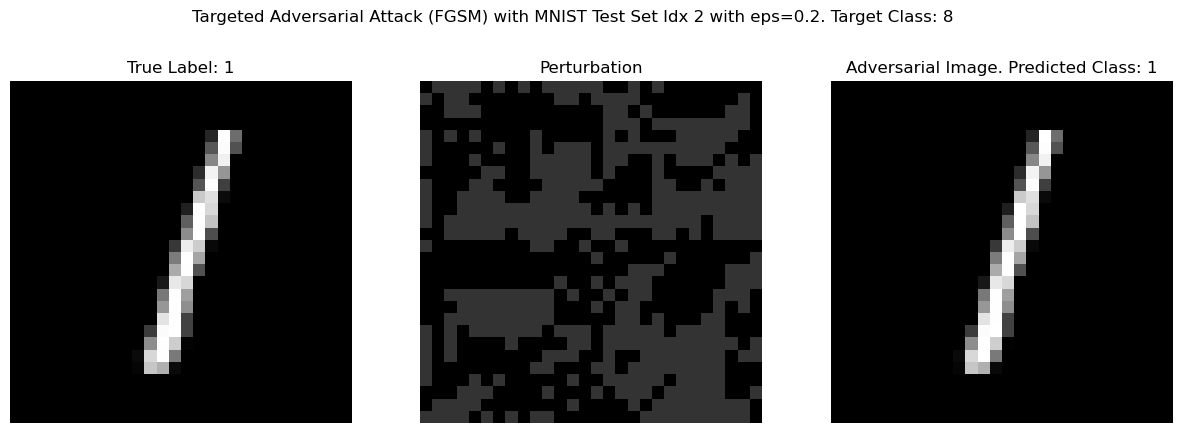

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -2.40   8.26   0.46  -3.01  -1.38  -4.54  -3.58  -1.74   2.04  -6.70
Magnitude of Perturbation: L1=84.00, L2=4.10


In [582]:
test_idx = 2  #@param
epsilon = 0.2
x, y = test_x[test_idx], test_y[test_idx]
y_target = 8

attack_img, perturbation = adversarial.fgsm_targeted(lenet5, x, y_target, epsilon=epsilon)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Targeted Adversarial Attack (FGSM) with MNIST Test Set Idx {test_idx} with eps={epsilon}. Target Class: {y_target}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

#### Projected Gradient Descent

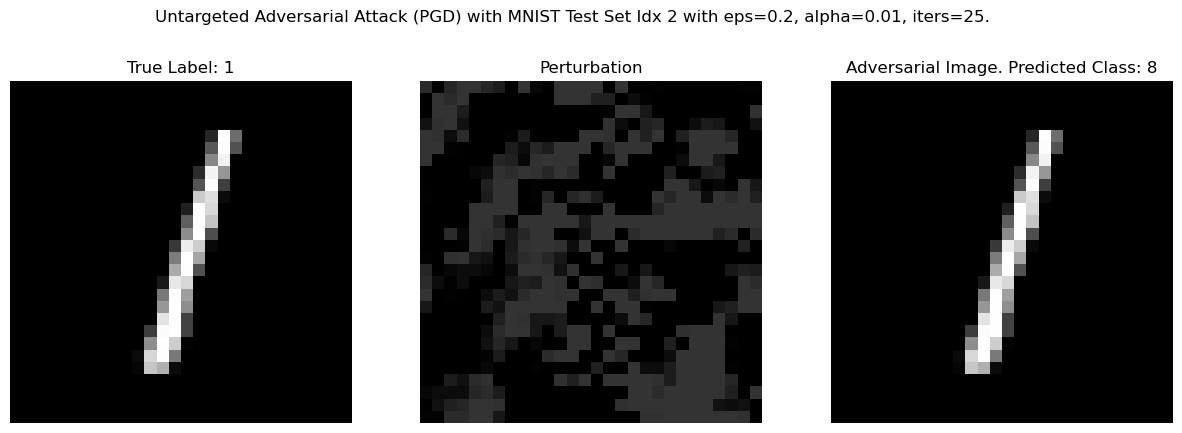

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -1.69   4.02  -2.16  -3.58  -2.45  -3.81  -0.94  -3.76   4.80  -5.44
Magnitude of Perturbation: L1=118.23, L2=4.58


In [583]:
test_idx = 2  #@param
epsilon = 0.2
alpha = 1e-2
num_iter = 25
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.pgd(lenet5, x, epsilon, alpha, num_iter, y)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Untargeted Adversarial Attack (PGD) with MNIST Test Set Idx {test_idx} with eps={epsilon}, alpha={alpha}, iters={num_iter}.')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

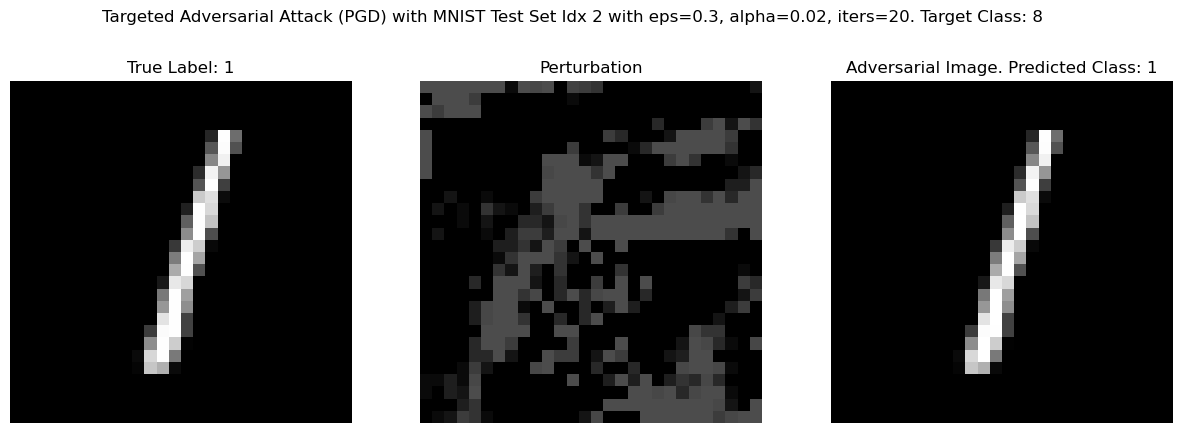

Labels:             0      1      2      3      4      5      6      7      8      9
Original Logits: -1.70   9.20   0.34  -4.81  -0.48  -6.10  -2.48  -1.30   0.38  -7.25
Attack Logits:   -1.43   6.36  -1.95  -5.37  -1.79  -4.23  -1.56  -3.40   3.96  -6.18
Magnitude of Perturbation: L1=85.52, L2=4.78


In [584]:
test_idx = 2  #@param
epsilon = 0.3
alpha = 2e-2
num_iter = 20
y_target = 8
x, y = test_x[test_idx], test_y[test_idx]

attack_img, perturbation = adversarial.pgd_targeted(lenet5, x, epsilon, alpha, num_iter, y_target)
attack_logits = lenet5(attack_img)
y_pred = int(attack_logits.argmax(axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle(f'Targeted Adversarial Attack (PGD) with MNIST Test Set Idx {test_idx} with eps={epsilon}, alpha={alpha}, iters={num_iter}. Target Class: {y_target}')
ax[0].imshow(x.squeeze(), cmap='grey'); ax[0].set_title(f'True Label: {y}'); ax[0].axis("off")
ax[1].imshow(perturbation.squeeze(), cmap='grey', vmin=0, vmax=1); ax[1].set_title(f'Perturbation'); ax[1].axis("off")
ax[2].imshow(attack_img.squeeze(), cmap='grey'); ax[2].set_title(f'Adversarial Image. Predicted Class: {y_pred}'); ax[2].axis("off"); plt.show()

# Compare logits before and after attack
attack_logits = attack_logits.squeeze().tolist()
real_logits = lenet5(x.unsqueeze(0)).squeeze().tolist()
labels = [i for i in range(10)]
print("Labels:        " + " ".join(f"{i:6d}" for i in labels))
print("Original Logits:" + " ".join(f"{x:6.2f}" for x in real_logits))
print("Attack Logits:  " + " ".join(f"{x:6.2f}" for x in attack_logits))

l1, l2 = adversarial.l1_distance_torch(x, attack_img), adversarial.l2_distance_torch(x, attack_img)
print(f'Magnitude of Perturbation: L1={l1:.2f}, L2={l2:.2f}')

#### Adversarial Training